In [419]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, ElasticNetCV
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, scale
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from patsy import dmatrix
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.base import BaseEstimator
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression

In [271]:
train_df = pd.read_csv('data/gss_train.csv')
test_df = pd.read_csv('data/gss_test.csv')

egalit_train = train_df.egalit_scale
income_train = train_df.income06.values
all_train = train_df.drop('egalit_scale', axis=1)
egalit_test = test_df.egalit_scale
income_test = test_df.income06.values
all_test = test_df.drop('egalit_scale', axis=1)

# Question 1 {-}

In [132]:
def polyreg(d):
    return make_pipeline(PolynomialFeatures(degree=d), LinearRegression())

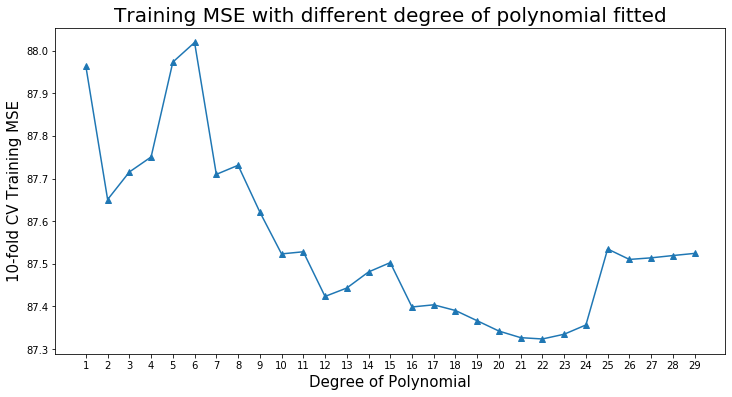

In [484]:
poly_MSE = []

degrees = np.arange(1,30,1)

for d in degrees:
    polyreg = poly_pipe(d)
    score = -1*cross_val_score(polyreg, income_train.reshape(-1,1), egalit_train.ravel(), 
                               cv=10, scoring='neg_mean_squared_error').mean()
    poly_MSE.append(score)

plt.figure(figsize=(12,6))
plt.plot(degrees, poly_MSE, marker='^')
plt.title('Training MSE with different degree of polynomial fitted', fontsize=20)
plt.xlabel('Degree of Polynomial', fontsize=15)
plt.ylabel('10-fold CV Training MSE', fontsize=15)
plt.xticks(degrees);

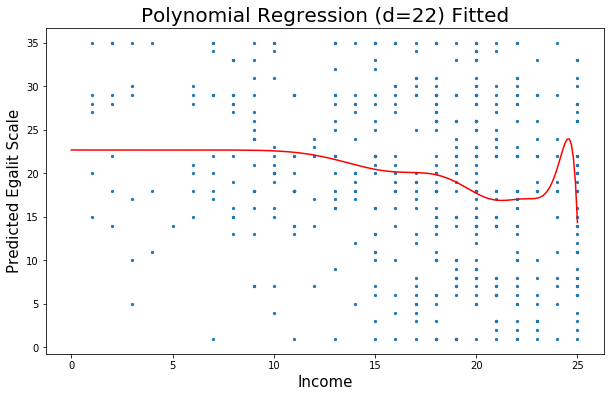

In [393]:
best_poly = poly_pipe(22).fit(income_train.reshape(-1,1), egalit_train)
plot_range = np.arange(0,25.1,0.1).reshape(-1,1)
y_preds = best_poly.predict(plot_range)

plt.figure(figsize=(10,6))
plt.plot(plot_range, y_preds, color='r')
plt.scatter(income_test, egalit_test, s=5)
plt.title('Polynomial Regression (d=22) Fitted', fontsize=20)
plt.xlabel('Income', fontsize=15)
plt.ylabel('Predicted Egalit Scale', fontsize=15);

The polynomial regression model at $d=22$ predicts that egalitarian score will start to decrease gradually from the income level of $\$12500$ to $\$14999$ until $\$110000$ to $\$129999$. Then, the egalitarian score quickly rises and peak at income level of $\$130000$ to $\$149999$, then suddenly drops after the peak. This might indicate that the low income group in general has relatively stable and actually quite high egalitarian scale. In the middle-to-high income group, the individual's egalitarianism decreases as the individual owns more household income. Interestingly, in the high income group, egalitarianism peaks, even higher than low income group. This might signify that a group of very wealthy households has high egalitarianism. But the sudden drop afterwards shows that the extremely wealthy people in the society has very low egalitarianism, that is, they take wealth all to their own pocket. 

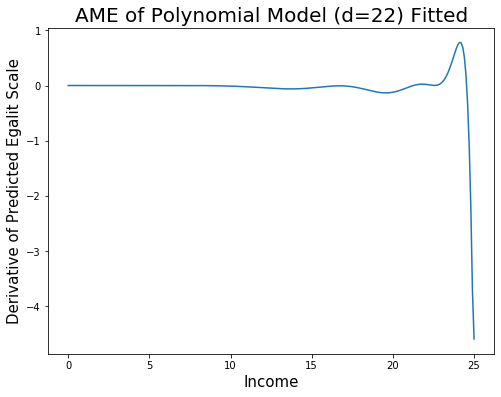

In [375]:
plt.figure(figsize=(8,6))
plt.plot(plot_range, np.gradient(y_preds))
plt.title('AME of Polynomial Model (d=22) Fitted', fontsize=20)
plt.xlabel('Income', fontsize=15)
plt.ylabel('Derivative of Predicted Egalit Scale', fontsize=15);

The AME confirms our observation in the previous graph. An individual that belongs to high income group will have a accelerating increase of egalitarianism. But those who are unfathomably rich has a decelerating egalitarianism score. The low and middle income group has almost no acceleration at all, which make their egalitarianism score quite stable. Taken together, we can observe the magical effect of money on a person's egalitarianism. People who just earned some money are less egalitarian, while people with substantial wealth are more egalitarian (donators to a number of welfare foundations, perhaps). Ultimately, the ultimate rich people don't care about the society's well-being at all.

# Question 2 {-}

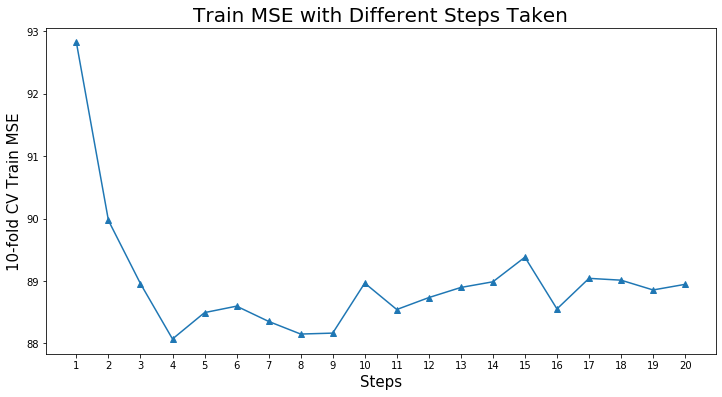

In [482]:
step_MSE = []
steps = np.arange(1,21,1)

for s in steps:
    df_cut, bins = pd.cut(train_df.income06, s, retbins=True, right=True)
    df_steps = pd.concat([train_df.income06, df_cut, egalit_train], 
                         keys=['income', 'income_cut', 'egalit_scale'], axis=1)
    df_steps_dummies = pd.get_dummies(df_steps['income_cut'])
    step_reg = LinearRegression()
    score = -1*cross_val_score(step_reg, df_steps_dummies, egalit_train.ravel(), 
                               cv=10, scoring='neg_mean_squared_error').mean()
    step_MSE.append(score)

plt.figure(figsize=(12,6))
plt.plot(steps, step_MSE, marker='^')
plt.xticks(steps)
plt.title('Train MSE with Different Steps Taken', fontsize=20)
plt.xlabel('Steps', fontsize=15)
plt.ylabel('10-fold CV Train MSE', fontsize=15);

The best step function has the optimal cut of 4.

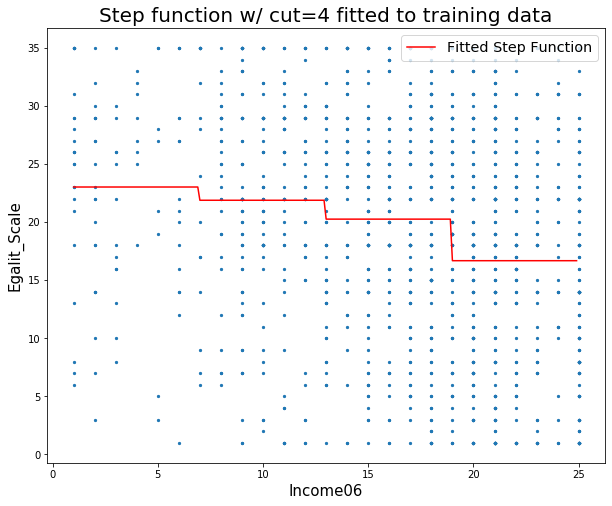

In [365]:
df_cut, bins = pd.cut(train_df.income06, 4, retbins=True, right=True)
df_steps = pd.concat([train_df.income06, df_cut, egalit_train], keys=['income', 'income_cut', 'egalit_scale'], axis=1)
df_steps_dummies = pd.get_dummies(df_steps['income_cut'])
income_grid = np.arange(train_df.income06.min(), train_df.income06.max(),0.1)
step_reg = LinearRegression().fit(df_steps_dummies, egalit_train)
bin_mapping = np.digitize(income_grid.ravel(), bins)

plt.figure(figsize=(10,8))
plt.plot(income_grid, step_reg.predict(pd.get_dummies(bin_mapping)), color='r', label='Fitted Step Function')
plt.scatter(income_train, egalit_train, s=5)
plt.title('Step function w/ cut=4 fitted to training data', fontsize=20)
plt.xlabel('Income06', fontsize=15)
plt.ylabel('Egalit_Scale', fontsize=15)
plt.legend(loc='upper right', fontsize='x-large');

# Question 3 {-}

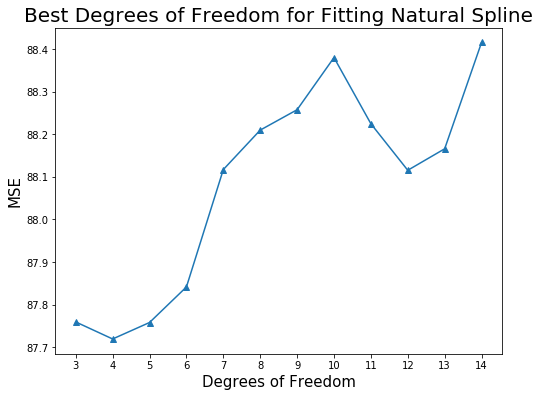

In [489]:
ns_MSE = []
df_range = np.arange(3,15)

for df in df_range:
    transformed_x = dmatrix(f"cr(train_df.income06, df={df}) - 1", 
                                data={"train_df.income06": train_df.income06}, return_type='dataframe')
    nslm = LinearRegression()
    score = -1*cross_val_score(nslm, transformed_x, egalit_train.ravel(), 
                               cv=10, scoring='neg_mean_squared_error').mean()
    ns_MSE.append(score)

plt.figure(figsize=(8,6))
plt.plot(df_range, ns_MSE, marker='^')
plt.xticks(df_range)
plt.title('Best Degrees of Freedom for Fitting Natural Spline', fontsize=20)
plt.xlabel('Degrees of Freedom', fontsize=15)
plt.ylabel('MSE', fontsize=15);

Hence the best degrees of freedom for fitting natural spline is 4.

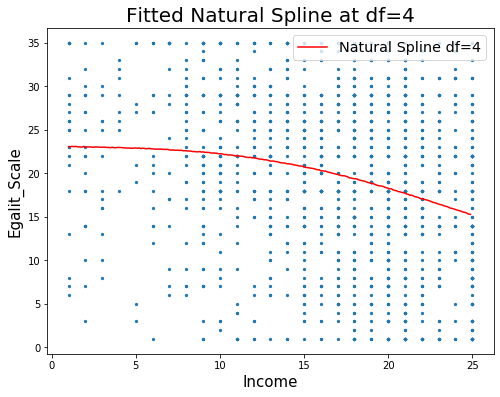

In [503]:
trans_income = dmatrix(f"cr(train_df.income06, df=4) - 1", 
                                data={"train_df.income06": train_df.income06}, return_type='dataframe')

trans_grid = dmatrix(f"cr(income_grid, df=4) - 1", data={"income_grid": income_grid}, return_type='dataframe')

ns_mod = LinearRegression().fit(trans_income, egalit_train)


plt.figure(figsize=(8,6))
plt.plot(income_grid, ns_mod.predict(trans_grid), color='r', label='Natural Spline df=4')
plt.scatter(income_train, egalit_train, s=5)
plt.title('Fitted Natural Spline at df=4', fontsize=20)
plt.xlabel('Income', fontsize=15)
plt.ylabel('Egalit_Scale', fontsize=15)
plt.legend(loc='upper right', fontsize='x-large');

# Question 4 {-}

In [407]:
all_train = all_train[all_train.var(axis=0).index]
all_test = all_test[all_test.var(axis=0).index]
all_train.head()

,age,authoritarianism,childs,con_govt,income06,science_quiz,sibs,social_connect,tolerance,tvhours,wordsum
0,21,4,0,4,25,7,2,5,10,3,5
1,42,4,2,2,23,10,1,5,13,3,6
2,70,1,3,4,19,4,0,5,10,3,6
3,35,2,2,2,16,7,2,10,11,3,6
4,24,6,3,3,5,5,2,4,7,2,4


In [437]:
X_train = StandardScaler().fit_transform(all_train, egalit_train)
y_train = egalit_train

### Linear Regression {-}

In [481]:
linear_mod = LinearRegression().fit(X_train, y_train)

score_a = -1*cross_val_score(linear_mod, all_test, egalit_test.ravel(), 
                               cv=10, scoring='neg_mean_squared_error').mean()

score_a

86.82184996870981

### Elastic Net {-}

In [480]:
param_range = np.arange(0.1, 1, 0.1)
el_mod = ElasticNetCV(l1_ratio=param_range, alphas=param_range, cv=10, random_state=1234).fit(X_train, y_train)

score_b = -1*cross_val_score(el_mod, all_test, egalit_test.ravel(), 
                               cv=10, scoring='neg_mean_squared_error').mean()
score_b

86.55445305275403

### PCR {-}

In [422]:
pca = PCA()
X_reduced = pca.fit_transform(X_train)
print(pca.components_.shape)

(11, 11)


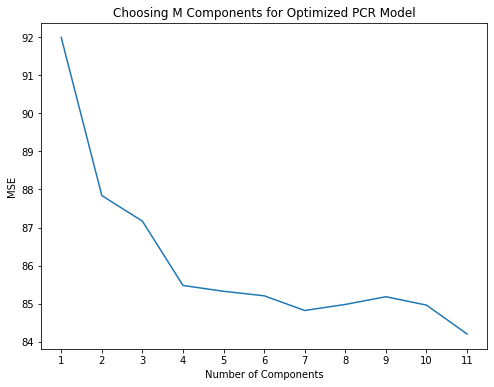

In [475]:
pcr_range = np.arange(1,12,1)
pcr_reg = LinearRegression()
pcr_MSE = []

for i in pcr_range:
    score = -1*cross_val_score(pcr_reg, X_reduced[:,:i], y_train.ravel(), 
                               cv=10, scoring='neg_mean_squared_error').mean()
    pcr_MSE.append(score)
    
plt.figure(figsize=(8,6))
plt.plot(pcr_range, pcr_MSE)
plt.xticks(pcr_range)
plt.title('Choosing M Components for Optimized PCR Model')
plt.xlabel('Number of Components')
plt.ylabel('MSE');

In [476]:
pcr_mod = LinearRegression().fit(X_reduced, y_train)

score_c = -1*cross_val_score(pcr_mod, all_test, egalit_test.ravel(), 
                               cv=10, scoring='neg_mean_squared_error').mean()

score_c

86.82184996870981

### PLS {-}

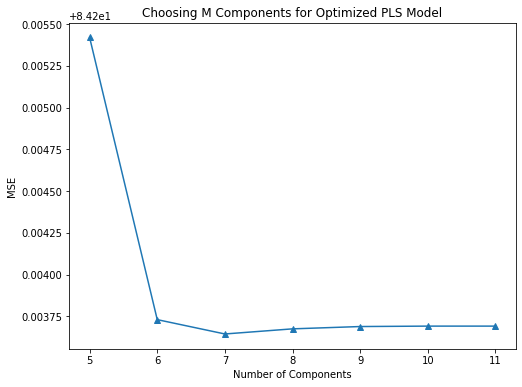

In [478]:
pls_range = np.arange(5,12) #Given we have 11 components in last analysis, [1,2,3,4] eliminated for high MSE
pls_MSE = []

for i in pls_range:
    pls = PLSRegression(n_components=i)
    score = -1*cross_val_score(pls, X_train, y_train, cv=10, scoring='neg_mean_squared_error').mean()
    pls_MSE.append(score)

plt.figure(figsize=(8,6))
plt.plot(pls_range, pls_MSE, marker='^')
plt.xticks(pls_range)
plt.title('Choosing M Components for Optimized PLS Model')
plt.xlabel('Number of Components')
plt.ylabel('MSE');

The optimized number of components in PLS is 7.

In [479]:
pls_mod = PLSRegression(n_components=7).fit(X_train, y_train)

score_d = -1*cross_val_score(pls_mod, all_test, egalit_test.ravel(), 
                               cv=10, scoring='neg_mean_squared_error').mean()

score_d

86.82198795408094

# Question 5 {-}

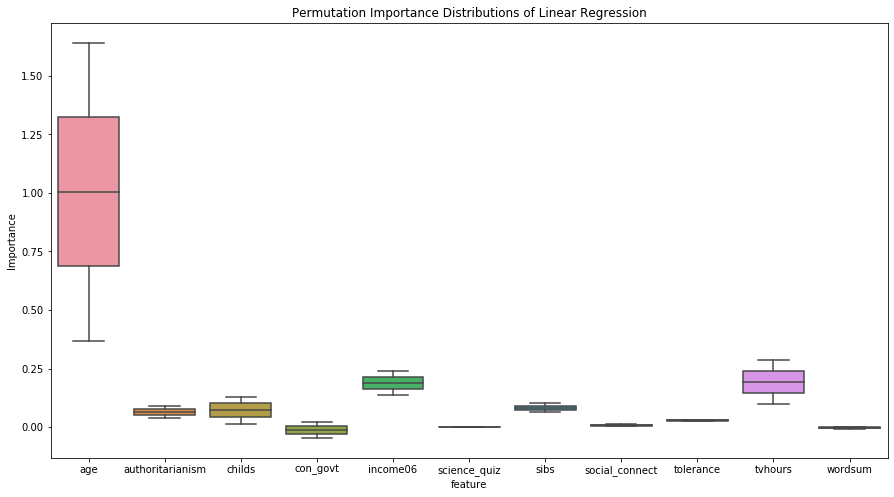

In [529]:
linear_fi = permutation_importance(linear_mod, all_test, egalit_test)
linear_d = {'feature': all_test.columns,
           'importances_mean': linear_fi['importances_mean'],
           'importances_std': linear_fi['importances_std']}
linear_df = pd.DataFrame(linear_d)
linear_df = linear_df.set_index('feature').T
plt.figure(figsize=(15,8))
sns.boxplot(data=linear_df).set(title='Permutation Importance Distributions of Linear Regression', ylabel='Importance');

In the linear regression model, age contributed to the most of prediction, income06 and tvhours follows.

In [536]:
el_fi = permutation_importance(el_mod, all_test, egalit_test)
el_d = {'feature': all_test.columns,
          'importances_mean': el_fi['importances_mean'],
        'importances_std': el_fi['importances_std']}
el_df = pd.DataFrame(el_d)
el_df
el_df = linear_df.set_index('feature').T
#plt.figure(figsize=(15,8))
#sns.boxplot(data=linear_df).set(title='Permutation Importance Distributions of Elastic Net Regression', ylabel='Importance');

KeyError: "None of ['feature'] are in the columns"